In [86]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [63]:
with open('average_scores_5:00.pickle', 'rb') as f:
    average_scores = pickle.load(f)

In [64]:
with open('predictions_5:00.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [65]:
with open('std_scores_5:00.pickle', 'rb') as f:
    std_scores = pickle.load(f)

In [66]:
stride = 3
average_scores = average_scores[0:len(predictions)*stride]
std_scores = std_scores[0:len(predictions)*stride]

In [70]:
reshaped_predictions = np.zeros((stride * len(predictions), 256, 256))

for i in range(predictions.shape[0]):
    for j in range(predictions.shape[1]):
        frame_index = i * 3 + j
        if frame_index < reshaped_predictions.shape[0]:
            if np.any(reshaped_predictions[frame_index] != 0):
                reshaped_predictions[frame_index] = (reshaped_predictions[frame_index] + predictions[i, j, :, :, 0]) / 2
            else:
                reshaped_predictions[frame_index] = predictions[i, j, :, :, 0]

reshaped_predictions.shape

(1785, 256, 256)

In [6]:
reshaped_predictions = predictions.reshape(-1, 256, 256, 1)

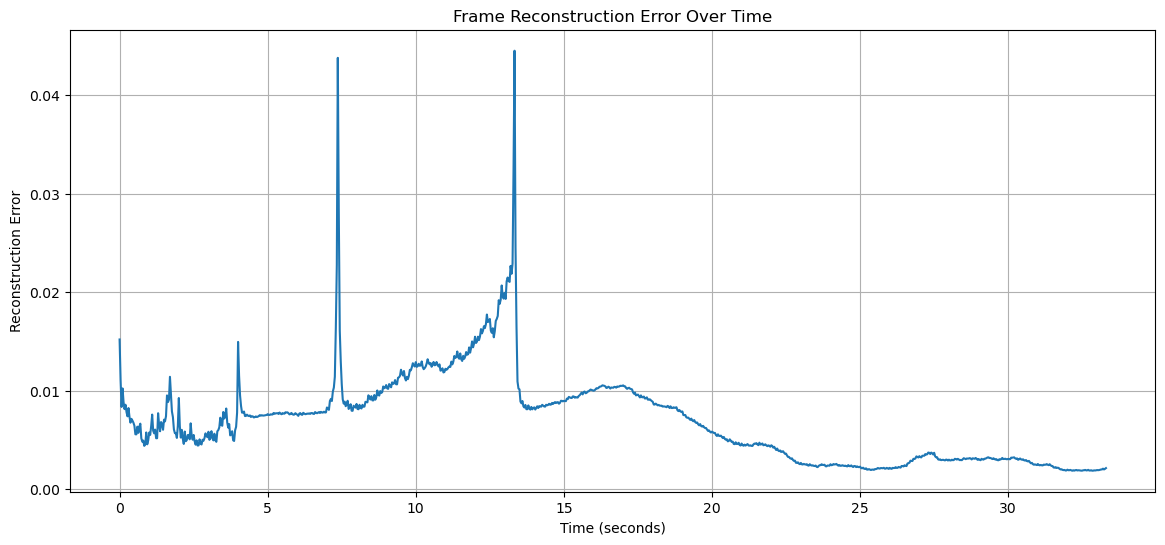

In [92]:
time_axis = np.arange(len(average_scores)) / 30

plt.figure(figsize=(14,6))
plt.plot(time_axis[0:1000], average_scores[0:1000])
plt.title("Frame Reconstruction Error Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Reconstruction Error")
plt.grid(True)

# plt.xticks(np.arange(0, max(time_axis) + 1, 5))  # Setting ticks at every 5 seconds

plt.show()

In [72]:
reshaped_predictions = (255 * reshaped_predictions).astype(np.uint8)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('prediction_video_5:00.mp4', fourcc, 30, (256, 256), isColor=False)

for i in range(len(reshaped_predictions)):
    frame = reshaped_predictions[i]

    frame = np.squeeze(frame)

    out.write(frame)

out.release()

In [27]:
cap = cv2.VideoCapture('full_video_2.mp4')

if not cap.isOpened():
    print("Error opening video file")

fps = cap.get(cv2.CAP_PROP_FPS)

# start_frame_number = int(5 * 60 * fps)
start_frame_number = int(5 * 60 * fps)
end_frame_number = start_frame_number + len(reshaped_predictions)

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)

while cap.isOpened():
    ret, frame = cap.read()
    if ret and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame_number:
        cv2.imshow('Frame', frame)

        # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()

cv2.destroyAllWindows()


In [75]:
3 * len(predictions)

1785

In [76]:
video_path = 'full_video_2.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")

fps = cap.get(cv2.CAP_PROP_FPS)

# start_frame_number = int(5 * 60 * fps)
start_frame_number = 5 * 60 * fps
end_frame_number = start_frame_number + len(reshaped_predictions)

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = 'original_video_5:00.mp4'
out = cv2.VideoWriter(output_video_path, fourcc, fps, (1024, 1024))

while cap.isOpened():
    ret, frame = cap.read()
    if ret and cap.get(cv2.CAP_PROP_POS_FRAMES) <= end_frame_number:
        resized_frame = cv2.resize(frame, (1024, 1024))
        
        # Write the resized frame to the output video
        out.write(resized_frame)
    else:
        break

cap.release()
out.release()

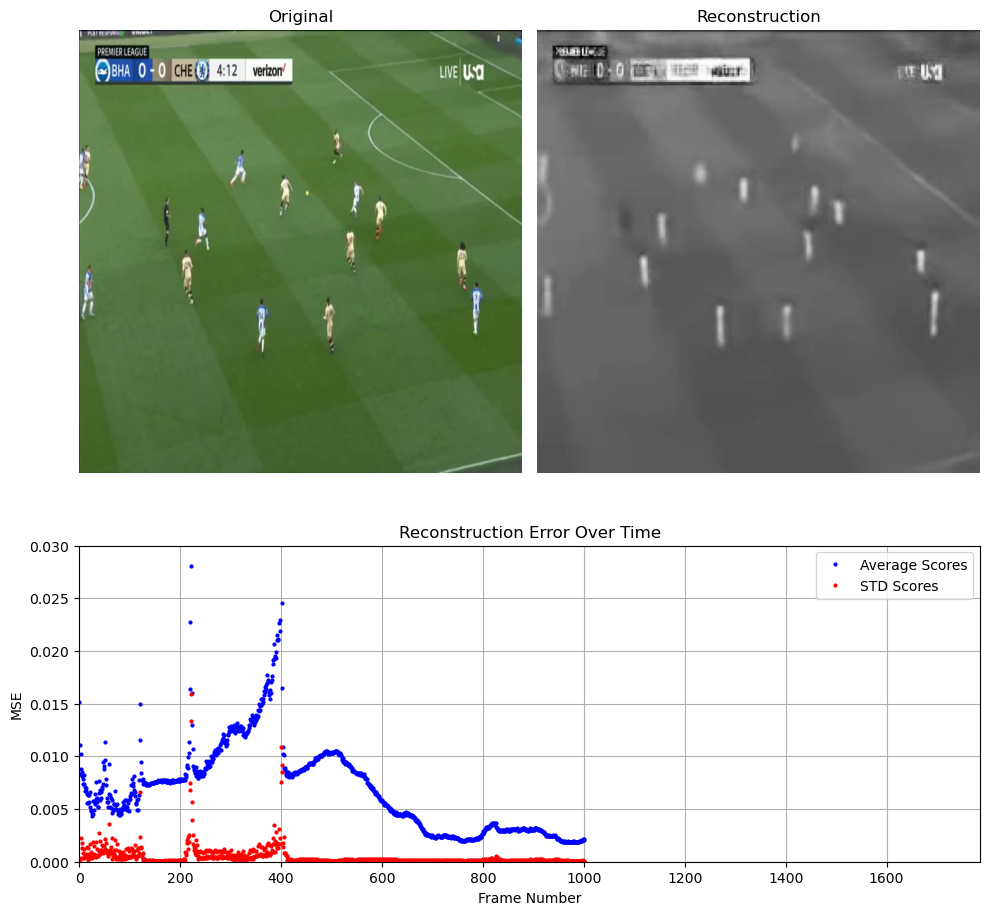

In [85]:
def extract_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = cap.read()
    if success:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def create_visual(frame_num, video1_path, video2_path, avg, std):
    # Extract frames
    frame1 = extract_frame(video1_path, frame_num)
    frame2 = extract_frame(video2_path, frame_num)
    
    fig = plt.figure(figsize=(10, 10))
    
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5], width_ratios=[1, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    if frame1 is not None:
        ax1.imshow(frame1)
        ax1.set_title("Original")
        ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    if frame2 is not None:
        ax2.imshow(frame2)
        ax2.set_title("Reconstruction")
        ax2.axis('off')  # Hide axis

    # Plot the line graph below
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(avg[:frame_num+1], 'b.', label='Average Scores', markersize=4)  # 'b.' plots blue dots
    ax3.plot(std[:frame_num+1], 'r.', label='STD Scores', markersize=4)  # 'b.' plots blue dots

    ax3.set_xlabel('Frame Number')
    ax3.set_ylabel('MSE')
    ax3.set_title('Reconstruction Error Over Time')
    ax3.grid(True)
    ax3.set_xlim(0, len(std_scores))
    ax3.set_ylim(0, 0.03)
    ax3.legend()
    plt.tight_layout()

    plt.show()

frame_number = 1001
video1_path = 'original_video_5:00.mp4'
video2_path = 'prediction_video_5:00.mp4'

create_visual(frame_number, video1_path, video2_path, average_scores, std_scores)

In [78]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def extract_frame(video_path, frame_num):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    success, frame = cap.read()
    if success:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        return None

def create_animation(video1_path, video2_path, output_path, avg, std):
    # Determine the total number of frames
    cap = cv2.VideoCapture(video1_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    # Create a figure for plotting
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5], width_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    FFMpegWriter = animation.writers['ffmpeg']
    writer = FFMpegWriter(fps=30)

    def update(frame_num):
        frame1 = extract_frame(video1_path, frame_num)
        frame2 = extract_frame(video2_path, frame_num)

        ax1.clear()
        ax2.clear()
        ax3.clear()

        if frame1 is not None:
            ax1.imshow(frame1)
            ax1.set_title("Original")
            ax1.axis('off')

        if frame2 is not None:
            ax2.imshow(frame2)
            ax2.set_title("Reconstruction")
            ax2.axis('off')

        ax3.plot(avg[:frame_num+1], 'b.', label='Average Scores', markersize=4)
        ax3.plot(std[:frame_num+1], 'r.', label='Standard Deviation Scores', markersize=4)
        ax3.set_xlabel('Frame Number')
        ax3.set_ylabel('MSE')
        ax3.set_title('Reconstruction Error Over Time')
        ax3.grid(True)
        ax3.set_xlim(0, len(avg))
        ax3.set_ylim(0, 0.03)
        ax3.legend()

    # Generate the animation
    with writer.saving(fig, output_path, 100):
        for i in range(total_frames):
            update(i)
            writer.grab_frame()
            plt.close(fig)

video1_path = 'original_video_5:00.mp4'
video2_path = 'prediction_video_5:00.mp4'
output_path = 'animation_2.mp4'

create_animation(video1_path, video2_path, output_path, average_scores, std_scores)